In [3]:
import numpy as np
from scipy.integrate import odeint

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["font.size"] = 12

# Base System

The receptor that activates the entire signaling pathway is $RTK$ (a generic Receptor Tyrosine Kinase). In modeling a typical signaling pathway, the concentration of $RTK$ is modeled as a function of time. For example, taking $RTK(t)$ to be an exponential decay function. However, we would like to model a cancer cell that is constitutively active, such that $ERK$ is held at a steady-state, non-zero level at all times. 

Also note that all protein concentrations (except for those with subscript $T$) are the concentrations of phosphorylated protein.

$RTK$ is the membrane receptor:

$$ \frac{dRTK}{dt} = \alpha_{RTK}f_n(SPRY) - \beta_{RTK}RTK $$

Activated $RTK$ begins a simple phosphorylation cascade to $SHP2$ and $RAS$:

$$ \frac{dSHP2}{dt} = \alpha_{SHP2} \cdot RTK \cdot [1 - \frac{SHP2}{SHP2_T} ] - \beta_{SHP2}SHP2 $$
$$ \frac{dRAS}{dt} = \alpha_{RAS} \cdot SHP2 \cdot [1 - \frac{RAS}{RAS_T} ] - \beta_{RAS}RAS $$

This phosphorylation cascade continues to $RAF$, $MEK$ and $ERK$. However, $RAF$ and $ERK$ each are subject to negative feedback. $RAF$ experiences negative feedback from the presence of $ERK$. $ERK$ experiences negative feedback from the presence of $DUSP$.

$$ \frac{dRAF}{dt} = \alpha_{RAF} \cdot f_n(ERK) \cdot RAS \cdot [1 - \frac{RAF}{RAF_T} ] - \beta_{RAF}RAF $$
$$ \frac{dMEK}{dt} = \alpha_{MEK} \cdot RAF \cdot [1 - \frac{MEK}{MEK_T} ] - \beta_{MEK}MEK $$
$$ \frac{dERK}{dt} = \alpha_{ERK} \cdot f_n(DUSP) \cdot MEK \cdot [1 - \frac{ERK}{ERK_T} ] - \beta_{ERK}ERK $$

$ERK$ induces transcription/translation of $DUSP$ and $SPRY$:

$$ \frac{dDUSP}{dt} = \alpha_{DUSP} \cdot f_p(ERK) - \beta_{DUSP}DUSP $$
$$ \frac{dSPRY}{dt} = \alpha_{SPRY} \cdot f_p(ERK) - \beta_{SPRY}SPRY $$

$f_n$ and $f_p$ are negative and positive feedback, respectively. $f_p$ is the hill function:

$$ f_p(x) = \frac{x^n}{K^n + x^n} $$

We define $f_n$ as follows:

$$ f_n(x) = 1 - f_p(x) = \frac{K^n}{K^n + x^n} $$

# A change to the base system

For simplicity, we should make the assumption that unphosphorylated signaling molecules are in excess and therefore the terms like $1 - \frac{SHP2}{SHP2_T}$ are always very close to 1. This doesn't seem necessary looking at the base system, but it makes our lives significantly easier when trying to model allosteric inhibitors. The system becomes as follows:

Phosphorylation cascade:

$$ \frac{dRTK}{dt} = \alpha_{RTK}f_n(SPRY) - \beta_{RTK}RTK $$
$$ \frac{dSHP2}{dt} = \alpha_{SHP2} \cdot RTK  - \beta_{SHP2}SHP2 $$
$$ \frac{dRAS}{dt} = \alpha_{RAS} \cdot SHP2 - \beta_{RAS}RAS $$
$$ \frac{dRAF}{dt} = \alpha_{RAF} \cdot f_n(ERK) \cdot RAS - \beta_{RAF}RAF $$
$$ \frac{dMEK}{dt} = \alpha_{MEK} \cdot RAF \cdot - \beta_{MEK}MEK $$
$$ \frac{dERK}{dt} = \alpha_{ERK} \cdot f_n(DUSP) \cdot MEK - \beta_{ERK}ERK $$

$ERK$ induces transcription/translation of $DUSP$ and $SPRY$:

$$ \frac{dDUSP}{dt} = \alpha_{DUSP} \cdot f_p(ERK) - \beta_{DUSP}DUSP $$
$$ \frac{dSPRY}{dt} = \alpha_{SPRY} \cdot f_p(ERK) - \beta_{SPRY}SPRY $$


In [107]:
labels = 'RTK,SHP2,RAS,RAF,MEK,ERK,DUSP,SPRY, SHP2i, MEKi'
labels = labels.split(',')
print(*[ f'{i} -> {label}' for i,label in enumerate(labels)], sep='\n')

0 -> RTK
1 -> SHP2
2 -> RAS
3 -> RAF
4 -> MEK
5 -> ERK
6 -> DUSP
7 -> SPRY
8 ->  SHP2i
9 ->  MEKi


# Modeling $SHP2$ and $MEK$ inhibitors

From literature, known MEK and SHP2 inhibitors are allosteric. We model each inhibitor as acting by forming a complex with its target signaling protein. We will set some non-zero initial concentration of the inhibitors. The differential equations for the inhibitors will be:

$$ \frac{dMEK_i}{dt} = -\gamma_{MEK_i} \cdot MEK_i \cdot MEK $$
$$ \frac{dSHP2_i}{dt} = -\gamma_{SHP2_i} \cdot SHP2_i \cdot SHP2 $$

The interaction of the inhibitors with their target will be modeled by modifying the differential equations for their targets:

$$ \frac{dMEK}{dt} = \alpha_{MEK} \cdot RAF  - \beta_{MEK}MEK - \gamma_{MEK_i} \cdot MEK_i \cdot MEK$$
$$ \frac{dSHP2}{dt} = \alpha_{SHP2} \cdot RTK - \beta_{SHP2}SHP2 -\gamma_{SHP2_i} \cdot SHP2_i \cdot SHP2 $$


In [6]:
def positive_feedback(x, k, n=1):
    # equal 0 when x = 0
    x_n = np.power(x, n)
    k_n = np.power(k, n)
    return x_n/(k_n + x_n)

def negative_feedback(x, k, n=1):
    # equal 1 when x = 0
    x_n = np.power(x, n)
    k_n = np.power(k, n)
    return k_n/(k_n + x_n)

def system_w_inhibitors(y, t, alpha, beta, k, gamma):
    # y has shape 10
    # alpha and beta have shape 8 - for each of the signaling molecules
    # k has shape 5 for the feedback mechanisms acting on RTK, RAF, ERK, DUSP, SPRY
    # gamma has shape 2 for the two inhibitors
    # 0 -> RTK
    # 1 -> SHP2
    # 2 -> RAS
    # 3 -> RAF
    # 4 -> MEK
    # 5 -> ERK
    # 6 -> DUSP
    # 7 -> SPRY
    # 8 ->  SHP2i
    # 9 ->  MEKi

    dy = np.zeros(y.shape)

    # compute MEKi and SHP2i inhibitor complexation rates
    shp2i_compelxation_rate = gamma[1]*y[1]*y[8]
    meki_complexation_rate = gamma[0]*y[4]*y[9]
    
    # model RTK concentration
    dy[0] = alpha[0]*negative_feedback(y[7], k[0], n=3) - beta[0]*y[0]

    # model SHP2
    dy[1] = alpha[1]*y[0] - beta[1]*y[1] - shp2i_compelxation_rate

    # model RAS
    dy[2] = alpha[2]*y[1] - beta[2]*y[2]

    # model RAF
    dy[3] = alpha[3]*y[2]*negative_feedback(y[5], k[1], n=3) - beta[3]*y[3]

    # model MEK
    dy[4] = alpha[4]*y[3] - beta[4]*y[4] - meki_complexation_rate

    # model ERK
    dy[5] = alpha[5]*negative_feedback(y[6], k[2], n=3)*y[4] - beta[5]*y[5]

    # model DUSP
    dy[6] = alpha[6]*positive_feedback(y[5], k[3], n=3) - beta[6]*y[6]

    # model SPRY
    dy[7] = alpha[7]*positive_feedback(y[5], k[4], n=3) - beta[7]*y[7]

    # model SHP2i
    dy[8] = -shp2i_compelxation_rate

    # model MEKi
    dy[9] = -meki_complexation_rate

    return dy

## functions for plotting results

In [9]:
def plot_cascade(t, y):
    labels = 'RTK,SHP2,RAS,RAF,MEK,ERK,DUSP,SPRY, SHP2i, MEKi'
    labels = labels.split(',')
    for i in range(y.shape[1]):
        if i not in [0, 1, 2, 3, 4, 5]: # members of phosphorylation cascade
            continue
        plt.plot(t, y[:,i], label=labels[i])
    plt.legend()

def plot_rtk_feedback(t, y):
    plt.plot(t, y[:, 0], label='RTK')
    plt.plot(t, y[:, 5], label='ERK')
    plt.plot(t, y[:, 7], label='SPRY')
    plt.legend()

# plotting base system

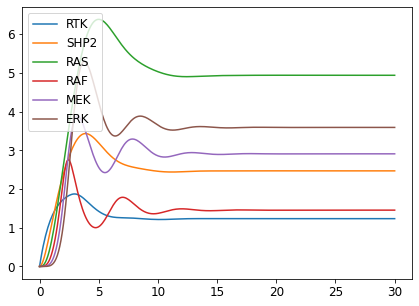

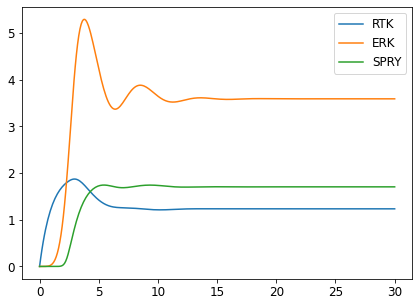

In [10]:
# set time points
t_base = np.linspace(0, 30, 300)

# set initial conditions
y0 = np.zeros(10)

# set parameters
alpha = np.ones(y0.shape[0] - 2)*2
beta = np.ones(y0.shape[0] - 2)
k = np.ones(5)*2
# k[0] = 3 # RTK regulation
# k[3] = 10 # how high can [ERK] get before DUSP is produced..which modulates ERK production
gamma = np.ones(2)
sys_args = (alpha, beta, k, gamma,)

# integrate system
y_base = odeint(system_w_inhibitors, t=t_base, y0=y0, args=sys_args)

# plot things
plot_cascade(t_base, y_base)
# plt.xlim((0, 30))
plt.show()
plot_rtk_feedback(t_base, y_base)
plt.show()

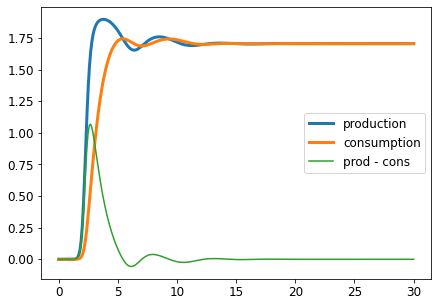

In [11]:
def spry_rate_analysis(t, y, alpha, beta, k, gamma):
    production = alpha[7]*positive_feedback(y[:, 5], k[4], n=3)
    consumption = beta[7]*y[:, 7]
    plt.plot(t, production, label='production', lw=3)
    plt.plot(t, consumption, label='consumption', lw=3)
    plt.plot(t, production - consumption, label='prod - cons')
    plt.legend()

spry_rate_analysis(t_base, y_base, alpha, beta, k, gamma)
plt.show()

# model system with MEKi only

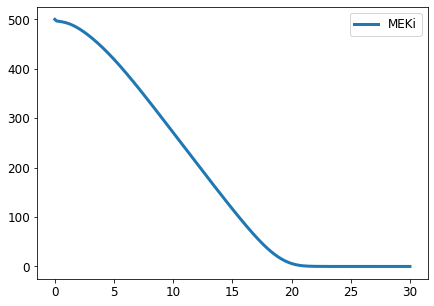

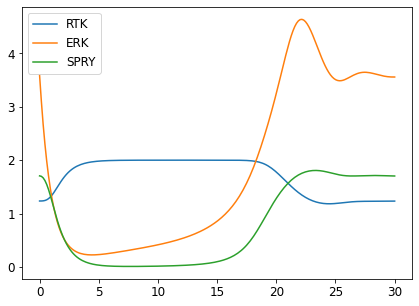

In [12]:
# getting steady-state values of base system
base_ss_levels = y_base[-1, :]

# set initial conditions
y0 = base_ss_levels
y0[9] = 500

# set time points
t = np.linspace(0, 30, 200)

# set parameters
alpha = np.ones(y0.shape[0] - 2)*2
beta = np.ones(y0.shape[0] - 2)
k = np.ones(5)*2
gamma = np.ones(2)*0.5
sys_args = (alpha, beta, k, gamma,)

# integrate system
y = odeint(system_w_inhibitors, t=t, y0=y0, args=sys_args)


# plot inhibitor concentration
plt.plot(t, y[:, 9], lw=3, label='MEKi')
plt.legend()
plt.show()

# plot things
# plot_cascade(t, y)
# plt.xlim((0, 30))
# plt.show()
plot_rtk_feedback(t, y)
plt.show()

# modeling dual MEKi and SHP2i addition

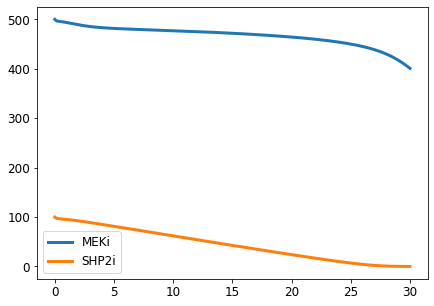

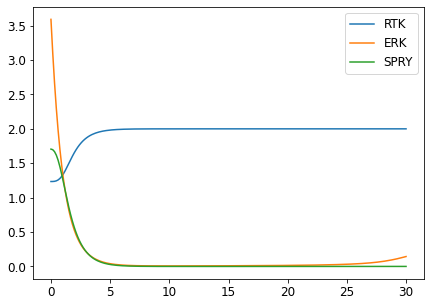

In [13]:
# getting steady-state values of base system
base_ss_levels = y_base[-1, :]

# set initial conditions
y0 = base_ss_levels
y0[9] = 500
y0[8] = 100

# set time points
t = np.linspace(0, 30, 200)

# set parameters
alpha = np.ones(y0.shape[0] - 2)*2
beta = np.ones(y0.shape[0] - 2)
k = np.ones(5)*2
gamma = np.ones(2)*0.5
sys_args = (alpha, beta, k, gamma,)

# integrate system
y = odeint(system_w_inhibitors, t=t, y0=y0, args=sys_args)


# plot inhibitor concentration
plt.plot(t, y[:, 9], lw=3, label='MEKi')
plt.plot(t, y[:, 8], lw=3, label='SHP2i')
plt.legend()
plt.show()

# plot things
# plot_cascade(t, y)
# plt.xlim((0, 30))
# plt.show()
plot_rtk_feedback(t, y)
plt.show()